In [27]:
# mounting the data through drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as pl


We are implementing Neural Networks for which we are taking the input of our optimised dataframe which is preprocessed(imputation and memory reduction). It consists of ~560K observations with 743 features. For Neural Networks, we would be taking the top 300 features based on their importance score.

In [0]:
#neural nets with reduced features
#include the path where the file is located
with open("/content/drive/My Drive/Info Viz/opti_df.pkl", "rb") as fp:
    pro = pickle.load(fp)

#features list:
#include the path where the file is located
#this is contains the dataframe which contains the features and their respective importance
with open("/content/drive/My Drive/Info Viz/feature_imp.pkl", "rb") as fp:
   f_i = pickle.load(fp)

In [30]:
print(f_i)

                        features  importance
74                           esi    0.044324
348          meds_cardiovascular    0.032196
42                           age    0.017116
192  meds_psychotherapeuticdrugs    0.016399
154        meds_gastrointestinal    0.015960
..                           ...         ...
457                  perintjaund    0.000000
487              ecodesmachinery    0.000000
581            ecodessuffocation    0.000000
362    bloodculture,routine_npos    0.000000
429      septicemiaexceptinlabor    0.000000

[743 rows x 2 columns]


In [0]:
# take the top 300 features based on their importance( ranked in descending order)
feat = f_i.head(300)['features'].tolist()
feat.append('disposition')
df = pd.DataFrame(pro,columns = feat)


In [32]:
# Split the dataframe as train and test in 80:20 ratio
del pro
y = df['disposition']
X = df.loc[:, df.columns != 'disposition']
Y = y.to_frame()
del df
del y

#scale X:
sc = StandardScaler()
X_a= sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_a, Y, test_size = 0.2, random_state = 0) 
# describes info about train and test set 
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (448388, 300)
Number transactions y_train dataset:  (448388, 1)
Number transactions X_test dataset:  (112098, 300)
Number transactions y_test dataset:  (112098, 1)


For various values for input nodes for the first layer , we train the model and get the confusion matrix,AUC, Fbeta score to narrow down the parameter which gives us the optimised model.

In [34]:

np.random.seed(1337) 
y_pred_dict = {}
roc_auc = {}
f_b = {}
f_beta_n = []
results = {}
first_layer = [20,30,50,60,80,100,250,300]
for i in first_layer:
  model = keras.Sequential([
      keras.layers.Dense(i, activation='relu'),
      keras.layers.Dense(30, activation='relu'),
      keras.layers.Dense(30, activation='relu'),
      keras.layers.Dense(1, activation = 'sigmoid'),
  ])
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy')
  model.fit(X_train, y_train, epochs=10)
  print(i)
  y_pred = model.predict_classes(X_test)
  fpr, tpr, _ = roc_curve(y_test,y_pred)
  roc_auc[i] = auc(fpr, tpr)
  print("AUC: ",auc(fpr, tpr))
  f_b[i] = fbeta_score(y_test['disposition'].ravel(), y_pred, beta=2.0)
  f_beta_n.append(f_b[i])
  print("Fbeta: ",f_b[i])
  results[i] = confusion_matrix(y_test['disposition'].ravel(), y_pred) 
  print("Confusion Matrix :", results[i])


Epoch 1/10
14013/14013 [==============================] - 20s 1ms/step - loss: 0.3426
Epoch 2/10
14013/14013 [==============================] - 20s 1ms/step - loss: 0.3323
Epoch 3/10
14013/14013 [==============================] - 20s 1ms/step - loss: 0.3293
Epoch 4/10
14013/14013 [==============================] - 21s 1ms/step - loss: 0.3288
Epoch 5/10
14013/14013 [==============================] - 20s 1ms/step - loss: 0.3285
Epoch 6/10
14013/14013 [==============================] - 22s 2ms/step - loss: 0.3287
Epoch 7/10
14013/14013 [==============================] - 20s 1ms/step - loss: 0.3291
Epoch 8/10
14013/14013 [==============================] - 20s 1ms/step - loss: 0.3292
Epoch 9/10
14013/14013 [==============================] - 20s 1ms/step - loss: 0.3305
Epoch 10/10
14013/14013 [==============================] - 21s 1ms/step - loss: 0.3305
20
AUC:  0.8068751818782751
Fbeta:  0.9270798143212843
Confusion Matrix : [[22471 10996]
 [ 4536 74095]]
Epoch 1/10
14013/14013 [==========

In [0]:
# save the AUC scores, Fbeta scores in a list for plotting
auc_nn = list(roc_auc.values())
#b = list(f_b.values())
y_preds_n = list(y_pred_dict.values())


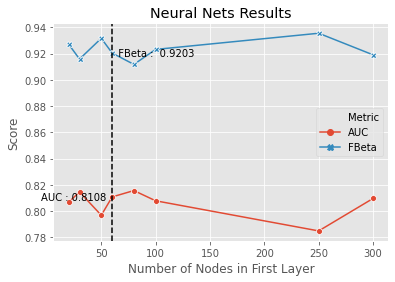

In [38]:
# Neural nets results as a plot
plt.style.use("ggplot")
first_layer = [20,30,50,60,80,100,250,300]
plot_data_n = pd.DataFrame({"First Layer" :first_layer , "AUC" : auc_nn , "FBeta" : f_beta_n})
melt_df_n = pd.melt(plot_data_n, value_vars=['AUC', 'FBeta'])

melt_df_n["First Layer"] =[20,30,50,60,80,100,250,300,20,30,50,60,80,100,250,300]
melt_df_n = melt_df_n.rename(columns={"variable": "Metric"})

ax = sns.lineplot(x="First Layer", y="value",
                  hue="Metric", style="Metric",
                  markers=True, dashes=False, data=melt_df_n)

ax.axvline(60, ls='--', color='black')

ax.text( 60, 0.8110, s= "AUC : 0.8108  ", color='black', horizontalalignment='right',verticalalignment='center')
ax.text( 60, 0.9200, s= "  FBeta :  0.9203", color='black', horizontalalignment='left',verticalalignment='center')

plt.xlabel('Number of Nodes in First Layer')
plt.ylabel('Score')
plt.title('Neural Nets Results')
plt.show()

We can see that the optimal model is achieved when number of nodes is first layer is 60. The false negatives are considerably less without any compromise on the AUC score.

In [42]:
#Optimised model when the number of nodes for the first layer is 60
#np.random.seed(1337) 
opt_model = keras.Sequential([
      keras.layers.Dense(60, activation='relu'),
      keras.layers.Dense(30, activation='relu'),
      keras.layers.Dense(30, activation='relu'),
      keras.layers.Dense(1, activation = 'sigmoid'),
  ])
opt_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy')
opt_model.fit(X_train, y_train, epochs=10)
y_pred = opt_model.predict_classes(X_test)
fpr, tpr, _ = roc_curve(y_test,y_pred)



Epoch 1/10
14013/14013 [==============================] - 25s 2ms/step - loss: 0.3389
Epoch 2/10
14013/14013 [==============================] - 23s 2ms/step - loss: 0.3304
Epoch 3/10
14013/14013 [==============================] - 23s 2ms/step - loss: 0.3296
Epoch 4/10
14013/14013 [==============================] - 23s 2ms/step - loss: 0.3319
Epoch 5/10
14013/14013 [==============================] - 22s 2ms/step - loss: 0.3319
Epoch 6/10
14013/14013 [==============================] - 22s 2ms/step - loss: 0.3314
Epoch 7/10
14013/14013 [==============================] - 23s 2ms/step - loss: 0.3330
Epoch 8/10
14013/14013 [==============================] - 23s 2ms/step - loss: 0.3323
Epoch 9/10
14013/14013 [==============================] - 23s 2ms/step - loss: 0.3341
Epoch 10/10
14013/14013 [==============================] - 23s 2ms/step - loss: 0.3348


TypeError: ignored

In [0]:
opt_model.save("nn_opt_model.h5")



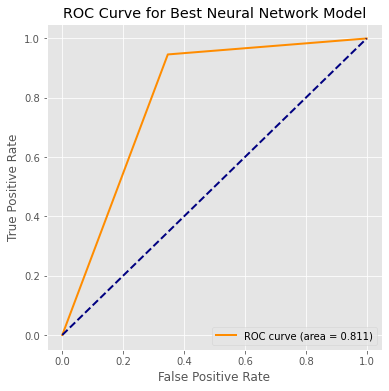

In [41]:
plt.style.use("ggplot")
plt.figure(figsize= (6,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % 0.8108
         )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Neural Network Model')
plt.legend(loc="lower right")
plt.show()